In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.base import ClusterMixin
from sklearn.base import BaseEstimator
sns.set(rc={'figure.figsize':(11.7,8.27)})
from random import *
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.manifold import MDS
from scipy.spatial.distance import cdist

In [2]:
def add_labels(x, y, labels, ax=None):
    """Ajoute les étiquettes `labels` aux endroits définis par `x` et `y`."""

    if ax is None:
        ax = plt.gca()
    for x, y, label in zip(x, y, labels):
        ax.annotate(
            label, [x, y], xytext=(10, -5), textcoords="offset points",
        )

    return ax

In [3]:
runner = pd.read_csv("../../../output/data_clean/cleaned_runner.csv", index_col=0)
race = pd.read_csv("../../../output/data_clean/cleaned_race_equivalent_distance.csv", index_col= 0)
runner.age_range = pd.Categorical(
    runner.age_range, categories=['16-25','26-40','40-60','61+','Undefined'],ordered=True
)
race.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1133 entries, 0 to 1206
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   race_year_id          1133 non-null   int64  
 1   event                 1133 non-null   object 
 2   race                  1133 non-null   object 
 3   country               1133 non-null   object 
 4   participation         1133 non-null   object 
 5   distance              1133 non-null   float64
 6   elevation_gain        1133 non-null   float64
 7   elevation_loss        1133 non-null   float64
 8   aid_stations          1133 non-null   int64  
 9   participants          1133 non-null   int64  
 10  country_code          1133 non-null   object 
 11  year                  1133 non-null   int64  
 12  month                 1133 non-null   int64  
 13  day                   1133 non-null   int64  
 14  frequency_in_ranking  1133 non-null   int64  
 15  equivalent_distance  

In [4]:
race = race.loc[race.distance > 150]

Index(['distance', 'elevation_gain', 'elevation_loss', 'participants',
       'aid_stations'],
      dtype='object')


<AxesSubplot:xlabel='axis1', ylabel='axis2'>

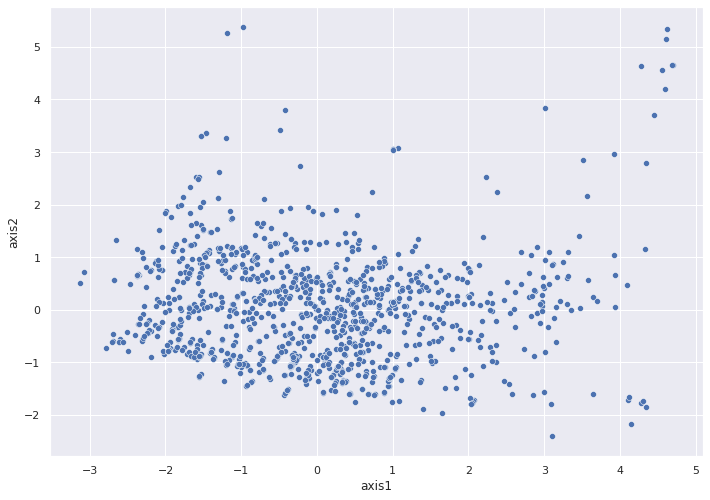

In [7]:
from sklearn.preprocessing import StandardScaler

df = race[["distance","elevation_gain","elevation_loss","participants","aid_stations"]]
print(df.columns)

cls = PCA(n_components=5)
pcs = cls.fit_transform(StandardScaler().fit_transform(df))

X = pd.DataFrame(pcs, columns=["axis1", "axis2","axis3","axis4","axis5"])
X.index = df.index
X['country'] = race.country
#X = pd.concat([X, join.age_range], axis=1)


sns.scatterplot(x = "axis1", y = "axis2", data = X)

In [31]:
cls.explained_variance_ratio_

array([0.44721082, 0.228595  , 0.17071409, 0.15228154, 0.00119854])

In [19]:
def scatterplot_pca(
    columns=None, hue=None, style=None, data=None, pc1=1, pc2=2, **kwargs
):
    """Diagramme de dispersion dans le premier plan principal.

    Permet d'afficher un diagramme de dispersion lorsque les données
    ont plus de deux dimensions. L'argument `columns` spécifie la
    liste des colonnes à utiliser pour la PCA dans le jeu de données
    `data`. Les arguments `style` et `hue` permettent de spécifier la
    forme et la couleur des marqueurs. Les arguments `pc1` et `pc2`
    permettent de sélectionner les composantes principales (par défaut
    la première et deuxième). Retourne l'objet `Axes` ainsi que le
    modèle `PCA` utilisé pour réduire la dimension.

    :param columns: Les colonnes quantitatives de `data` à utiliser
    :param hue: La colonne de coloration
    :param style: La colonne du style
    :param data: Le dataFrame Pandas
    :param pc1: La composante en abscisse
    :param pc2: La composante en ordonnée

    """
     # Select relevant columns (should be numeric)
    data_quant = data if columns is None else data[columns]
    data_quant = data_quant.drop(
        columns=[e for e in [hue, style] if e is not None], errors="ignore"
    )

    # Reduce to two dimensions if needed
    if data_quant.shape[1] == 2:
        data_pca = data_quant
        pca = None
    else:
        n_components = max(pc1, pc2)
        pca = PCA(n_components=n_components)
        data_pca = pca.fit_transform(data_quant)
        data_pca = pd.DataFrame(
            data_pca[:, [pc1 - 1, pc2 - 1]], columns=[f"PC{pc1}", f"PC{pc2}"]
        )

    # Keep name, force categorical data for hue and steal index to
    # avoid unwanted alignment
    if isinstance(hue, pd.Series):
        if not hue.name:
            hue.name = "hue"
        hue_name = hue.name
    elif isinstance(hue, str):
        hue_name = hue
        hue = data[hue]
    elif isinstance(hue, np.ndarray):
        hue = pd.Series(hue, name="class")
        hue_name = "class"

    hue = hue.astype("category")
    hue.index = data_pca.index
    hue.name = hue_name

    if isinstance(style, pd.Series):
        if not style.name:
            style.name = "style"
        style_name = style.name
    elif isinstance(style, str):
        style_name = style
        style = data[style]
    elif isinstance(style, np.ndarray):
        style = pd.Series(style, name="style")
        style_name = "style"

    full_data = data_pca
    if hue is not None:
        full_data = pd.concat((full_data, hue), axis=1)
        kwargs["hue"] = hue_name
    if style is not None:
        full_data = pd.concat((full_data, style), axis=1)
        kwargs["style"] = style_name

    x, y = data_pca.columns
    ax = sns.scatterplot(x=x, y=y, data=full_data, **kwargs)

    return ax, pca

<AxesSubplot:xlabel='axis1', ylabel='axis2'>

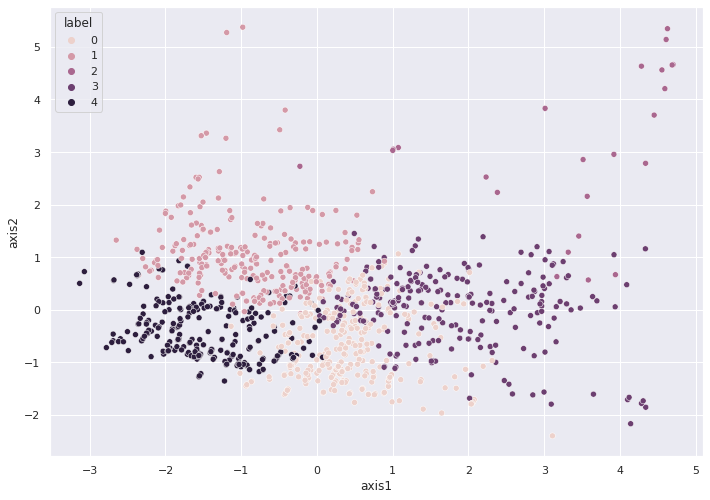

In [29]:
cls1 = KMeans(n_clusters=5, init="k-means++",n_init=100)
cls1.fit(StandardScaler().fit_transform(df))

df = race[["distance","elevation_gain","elevation_loss","participants","aid_stations"]]

cls = PCA(n_components=5)
pcs = cls.fit_transform(StandardScaler().fit_transform(df))

X = pd.DataFrame(pcs, columns=["axis1", "axis2","axis3","axis4","axis5"])
X.index = df.index
X['label'] = cls1.labels_
#X = pd.concat([X, join.age_range], axis=1)


sns.scatterplot(x = "axis1", y = "axis2", hue = "label", data = X)

In [109]:
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist

In [110]:
race.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1126 entries, 0 to 1206
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   race_year_id          1126 non-null   int64  
 1   event                 1126 non-null   object 
 2   race                  1126 non-null   object 
 3   country               1126 non-null   object 
 4   participation         1126 non-null   object 
 5   distance              1126 non-null   float64
 6   elevation_gain        1126 non-null   float64
 7   elevation_loss        1126 non-null   float64
 8   aid_stations          1126 non-null   int64  
 9   participants          1126 non-null   int64  
 10  country_code          1126 non-null   object 
 11  year                  1126 non-null   int64  
 12  month                 1126 non-null   int64  
 13  day                   1126 non-null   int64  
 14  frequency_in_ranking  1126 non-null   int64  
 15  equivalent_distance  

In [115]:
df = race.drop(columns=["country","participation","event","race",'race_year_id','country_code'])
df

,distance,elevation_gain,elevation_loss,aid_stations,participants,year,month,day,frequency_in_ranking,equivalent_distance,weighted_elevation
0,166.9,4520.0,-4520.0,10,150,2021,9,3,25,212.1,0.213107
1,170.7,9930.0,-9930.0,11,2300,2021,8,27,1526,270.0,0.367778
2,167.0,9980.0,-9980.0,13,600,2021,8,20,455,266.8,0.374063
3,164.0,7490.0,-7500.0,13,150,2021,8,20,55,238.9,0.313520
4,159.9,100.0,-100.0,12,13,2021,8,20,13,160.9,0.006215
...,...,...,...,...,...,...,...,...,...,...,...
1202,161.0,1600.0,-1600.0,0,114,2012,3,3,114,177.0,0.090395
1203,161.0,4000.0,-4000.0,0,15,2012,2,24,15,201.0,0.199005
1204,161.0,2400.0,-2400.0,0,25,2012,2,10,25,185.0,0.129730
1205,161.0,1800.0,-1800.0,0,218,2012,2,4,218,179.0,0.100559


In [116]:
X = pd.DataFrame(
    squareform(pdist(df)),
    columns = df.index,
    index = df.index
)

In [117]:
X

,0,1,2,3,4,5,6,7,8,9,...,1197,1198,1199,1200,1201,1202,1203,1204,1205,1206
0,0.000000,8087.993934,7746.863309,4207.520132,6252.573669,7539.448768,1335.488413,190.230413,2556.309413,2009.050274,...,2930.387069,333.111723,1306.620764,4923.365214,3651.456535,4130.799055,748.300755,3000.912066,3852.276526,4385.463240
1,8087.993934,0.000000,2010.501910,4318.090562,14170.017910,2488.330203,6885.379669,7899.523043,5731.698199,10023.152804,...,10882.286221,8410.962021,9354.372193,3863.286307,4853.298723,12064.811899,8822.655389,10992.646276,11757.913512,4236.119207
2,7746.863309,2010.501910,0.000000,3565.639832,13992.140628,536.632994,6432.946900,7565.576197,5206.299843,9753.388250,...,10663.224969,8063.672356,9050.502532,2893.000111,4139.380587,11866.336466,8488.892311,10744.088528,11577.356344,3408.026432
3,4207.520132,4318.090562,3565.639832,0.000000,10459.385016,3333.924274,2881.002134,4030.974288,1660.076149,6216.070041,...,7135.571567,4520.072900,5509.814210,727.228582,577.684525,8337.342602,4944.863236,7206.797156,8056.142505,206.261703
4,6252.573669,14170.017910,13992.140628,10459.385016,0.000000,13791.964269,7580.422582,6430.784753,8805.427048,4243.714871,...,3329.191401,5939.971958,4949.995197,11172.589464,9899.756619,2126.311696,5515.604614,3252.880421,2421.754700,10635.276724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202,4130.799055,12064.811899,11866.336466,8337.342602,2126.311696,11669.224235,5460.561860,4307.599525,6683.516099,2124.497255,...,1203.514957,3820.160470,2830.837510,9052.214484,7779.738495,0.000000,3397.148806,1138.400633,318.807152,8514.328928
1203,748.300755,8822.655389,8488.892311,4944.863236,5515.604614,8278.355453,2064.916609,932.688614,3292.695768,1276.068565,...,2200.395477,425.356321,566.338238,5656.998587,4384.174154,3397.148806,0.000000,2262.885769,3124.628299,5119.778653
1204,3000.912066,10992.646276,10744.088528,7206.797156,3252.880421,10539.782058,4327.642478,3180.222391,5553.331742,993.410983,...,191.552212,2687.192588,1697.204467,7919.810922,6646.996241,1138.400633,2262.885769,0.000000,891.386561,7382.440239
1205,3852.276526,11757.913512,11577.356344,8056.142505,2421.754700,11386.251211,5183.536652,4026.485672,6402.863066,1855.008836,...,924.673051,3545.074049,2558.991404,8772.881343,7501.238101,318.807152,3124.628299,891.386561,0.000000,8234.528298


In [118]:
mds_Xprime = MDS(n_components=2, dissimilarity='precomputed')
aftd_Xprime = mds_Xprime.fit_transform(X)

<AxesSubplot:xlabel='axis1', ylabel='axis2'>

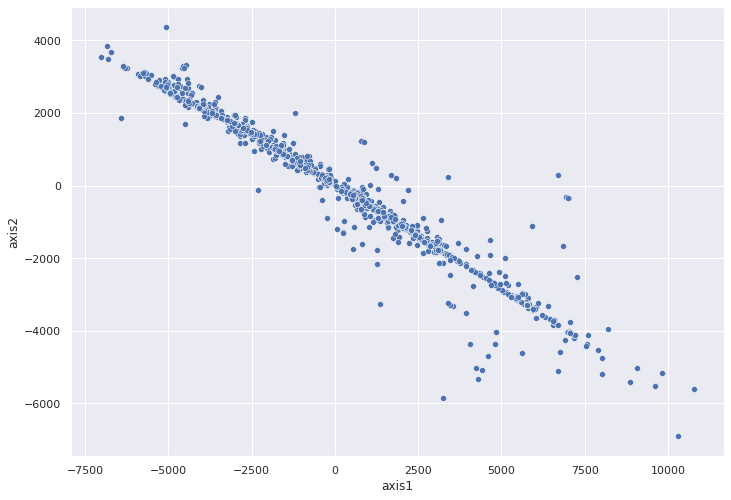

In [119]:
new_Xprime = pd.DataFrame(aftd_Xprime, columns=["axis1","axis2"])
sns.scatterplot(
    x = "axis1",
    y = "axis2",
    data = new_Xprime
)
#add_labels(new_Xprime.axis1, new_Xprime.axis2, new_Xprime.index)

In [120]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import ClusterWarning
from warnings import simplefilter
simplefilter("ignore", ClusterWarning)

In [121]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    default_kwargs = dict(leaf_font_size=10)
    default_kwargs.update(kwargs or {})

    dendrogram(linkage_matrix, **default_kwargs)


In [122]:
cls = AgglomerativeClustering(linkage="ward", affinity="euclidean", distance_threshold=0, n_clusters=None)

In [123]:
cls.fit(df)

AgglomerativeClustering(distance_threshold=0, n_clusters=None)

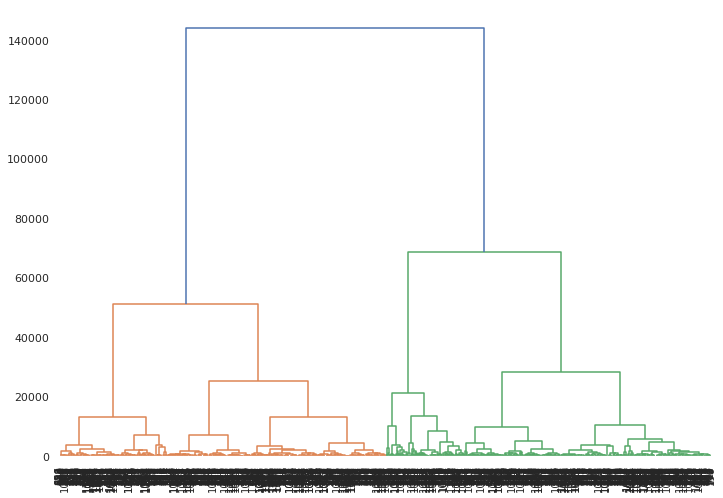

In [124]:
plot_dendrogram(cls)

/home/romain/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


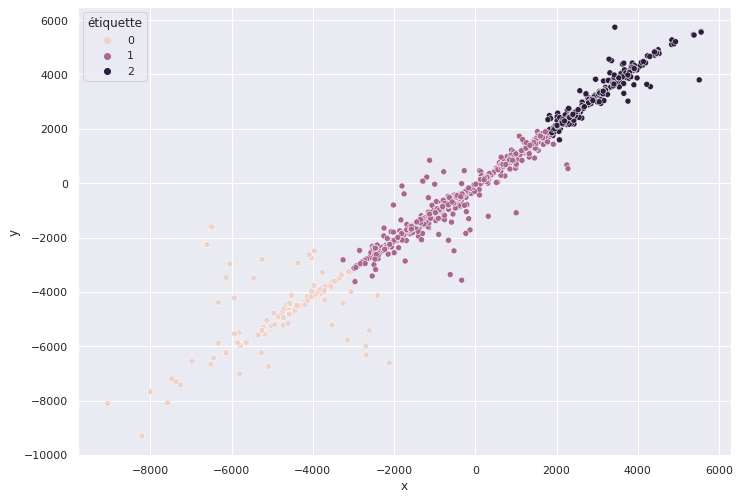

In [130]:
model = AgglomerativeClustering(
    affinity="precomputed", linkage="complete", n_clusters=3
).fit(X)

labels = model.labels_

aftd = MDS(n_components=2, dissimilarity="precomputed")
dist = aftd.fit_transform(X)

df = pd.DataFrame({"x": dist[:, 0], "y": dist[:, 1], "étiquette": labels})

sns.scatterplot("x", "y", hue="étiquette", data=df)
# add_labels(dist[:, 0], dist[:, 1], X.index)
plt.show()

In [131]:
race = race.assign( label = labels)
race

,race_year_id,event,race,country,participation,distance,elevation_gain,elevation_loss,aid_stations,participants,country_code,year,month,day,frequency_in_ranking,equivalent_distance,weighted_elevation,label
0,68140,Peak District Ultras,Millstone 100,United Kingdom,solo,166.9,4520.0,-4520.0,10,150,GBR,2021,9,3,25,212.1,0.213107,1
1,72496,UTMB®,UTMB®,France,solo,170.7,9930.0,-9930.0,11,2300,FRA,2021,8,27,1526,270.0,0.367778,0
2,69855,Grand Raid des Pyrénées,Ultra Tour 160,France,solo,167.0,9980.0,-9980.0,13,600,FRA,2021,8,20,455,266.8,0.374063,0
3,67856,Persenk Ultra,PERSENK ULTRA,Bulgaria,solo,164.0,7490.0,-7500.0,13,150,BGR,2021,8,20,55,238.9,0.313520,1
4,70469,Runfire Salt Lake Ultra,100 Mile,Turkey,solo,159.9,100.0,-100.0,12,13,TUR,2021,8,20,13,160.9,0.006215,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202,2320,Centurion Thames Path 100,Centurion Thames Path 100,United Kingdom,solo,161.0,1600.0,-1600.0,0,114,GBR,2012,3,3,114,177.0,0.090395,2
1203,3439,RUN2KILL,RUN2KILL,Germany,solo,161.0,4000.0,-4000.0,0,15,DEU,2012,2,24,15,201.0,0.199005,1
1204,5640,IRON HORSE Endurance RunS,IRON HORSE 100M,United States,solo,161.0,2400.0,-2400.0,0,25,USA,2012,2,10,25,185.0,0.129730,2
1205,3202,Rocky Raccoon,100 Mile,United States,solo,161.0,1800.0,-1800.0,0,218,USA,2012,2,4,218,179.0,0.100559,2


<AxesSubplot:>

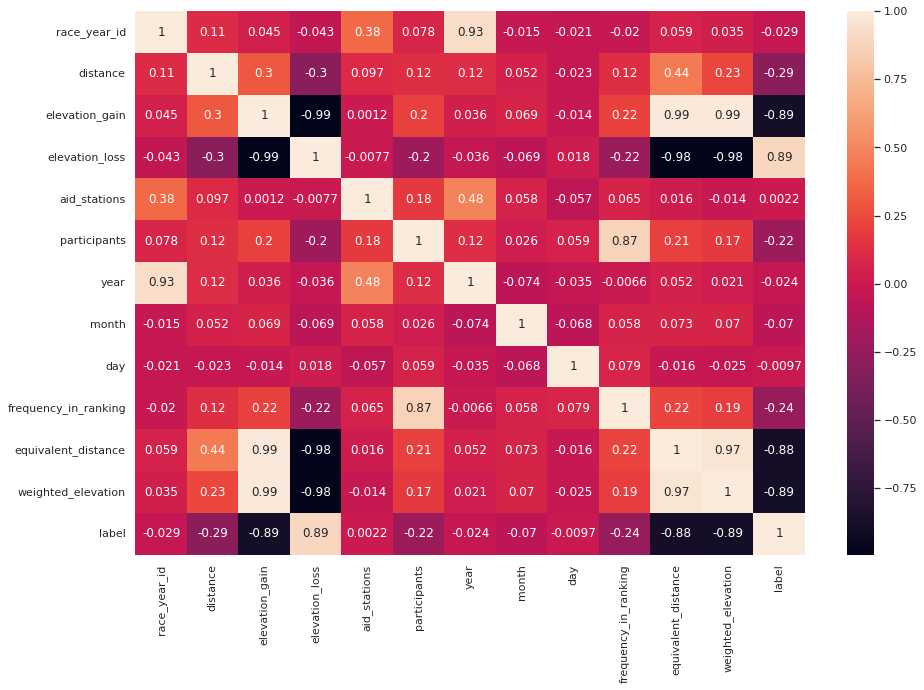

In [132]:
plt.figure(figsize=(15,10))
sns.heatmap(race.corr(), annot=True)

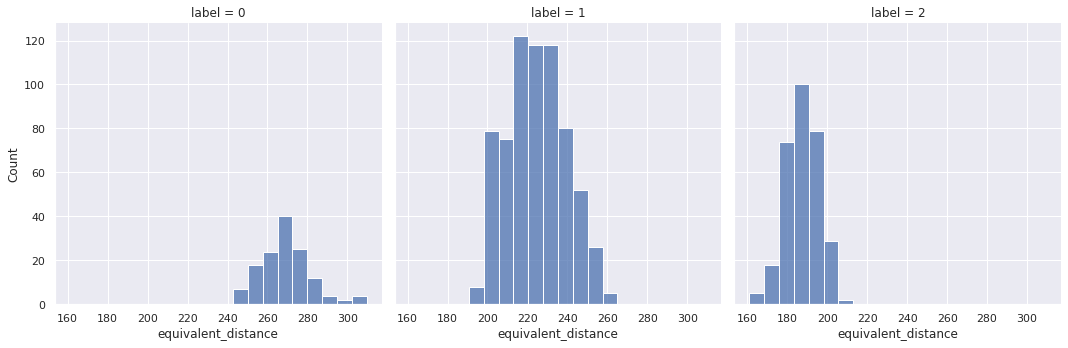

In [135]:
sns.displot(
    x = "equivalent_distance",
    col = "label",
    data = race
)

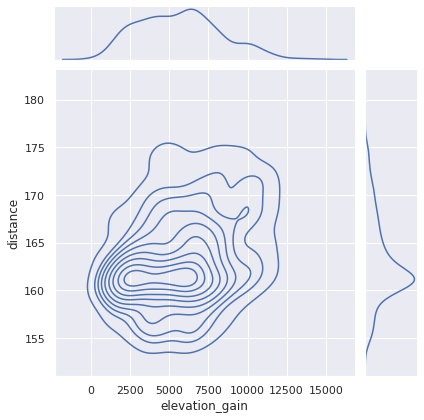

In [150]:
sns.jointplot(data=race, x="elevation_gain", y="distance", kind="kde")

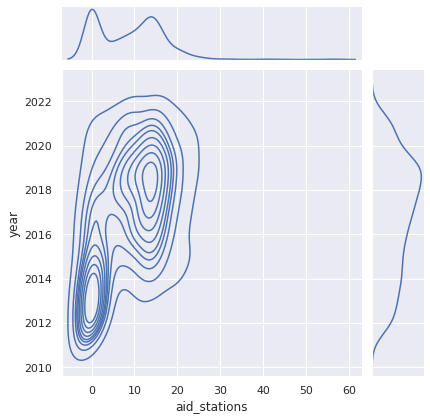

In [147]:
sns.jointplot(data=race, x="aid_stations", y="year", kind="kde")

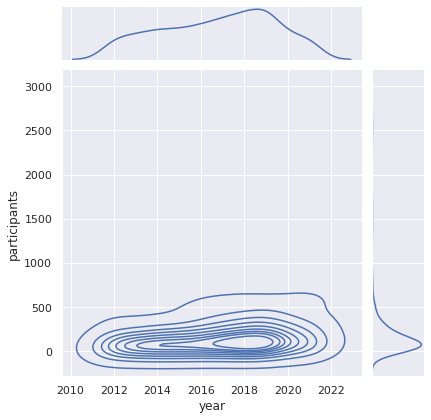

In [151]:
sns.jointplot(data=race, x="year", y="participants", kind="kde")